Aanvraag / besluit classifier

In [18]:
import numpy as np
import math
from PIL import Image
from scipy import misc
import keras
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import calibration_curve

%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
 
from examples.aanvraag_besluit.load_data import load_data_aanvraag, preprocess_X
from examples.aanvraag_besluit.transformer import Transformer

from src.stats import list_stats, show_train_curves, show_prediction_list, show_prediction_images_new
from src.data import split_data
from src.image_display import show_image
from src import models as own_models

# Hot reload packages
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load dataset

In [ ]:
img_dim = (200, 200, 3);
img_dim = (250, 250, 3);
# img_dim = (300, 300, 3);
# img_dim = (400, 400, 3);

[Xtrain_raw, Ytrain_raw, Xvalid_raw, Yvalid_raw] = load_data_aanvraag(
    {
        'images': f'examples/aanvraag_besluit/eerste_dataset/resized/{img_dim[0]}x{img_dim[1]}/',
        'labels': 'examples/aanvraag_besluit/eerste_dataset/labels/'
    },
    {
        'images': f'examples/aanvraag_besluit/tweede_dataset/images/{img_dim[0]}x{img_dim[1]}/',
        'labels': 'examples/aanvraag_besluit/tweede_dataset/labels/'
    },
)

print(f"shape Xtrain[0]: {Xtrain_raw[0].shape}")
print(f"shape Xtrain[1]: {Xtrain_raw[1].shape}")
print(f"shape Ytrain: {Ytrain_raw.shape}")

print(f"shape Xvalid[0]: {Xvalid_raw[0].shape}")
print(f"shape Xvalid[1]: {Xvalid_raw[1].shape}")
print(f"shape Yvalid: {Yvalid_raw.shape}")

loading set1
first few ids: ['SA00006999_00001', 'SA00009974_00001', 'SA00009975_00001', 'SA00009978_00001', 'SA00010588_00001']
loading set2
first few ids: ['SU10100825_00001', 'SU10100826_00001', 'SU10100916_00001', 'SU10102968_00001', 'SU10102969_00001']


In [4]:
# Preprocess (encode, transform features and labels)
transformer = Transformer()

Xdata_mix = Xtrain_raw[1].append(Xvalid_raw[1])
transformer.fit(Xdata_mix)

Xtrain = preprocess_X(Xtrain_raw[0], Xtrain_raw[1], transformer)
Xvalid = preprocess_X(Xvalid_raw[0], Xvalid_raw[1], transformer)
# print(Xtrain[1][:4])
# print(transformer.decode(Xtrain[1][:4]))
print(Xvalid[1][:4])
print(transformer.decode(Xvalid[1][:4]))

num_features = Xtrain[1].shape[1]
print(Xvalid[1].shape)
assert Xvalid[1].shape[1] == num_features

/Volumes/CaseSensitiveWorkspace/gem-ams/stadarchief-ml/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[[0.07142857 0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.02857143 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.         0.        ]
 [0.41428571 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.        ]
 [0.38571429 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.         0.         0.
  0.         0.        ]]
  dossier_jaar           dossier_type stadsdeel_code
0       1985.0             oprichting             SU
1       1982.0             verbouwing             SU
2       2009.0      

In [5]:
classes = list(set(Ytrain_raw))
print(classes)
num_classes = 2
assert len(classes) == num_classes


print('')
print('--- TRAIN ---')
list_stats(Ytrain_raw)

print('')
print('--- VALID ---')
list_stats(Yvalid_raw)

['aanvraag', 'other']

--- TRAIN ---
classes: 2
classes with count less than 5 ignored
count classes: [['aanvraag', 420], ['other', 383]]
largest class: aanvraag, count: 420
total count: 803
score to beat: 0.523038605230386

--- VALID ---
classes: 2
classes with count less than 5 ignored
count classes: [['aanvraag', 170], ['other', 227]]
largest class: other, count: 227
total count: 397
score to beat: 0.5717884130982368


In [6]:
# enc = preprocessing.LabelEncoder()  # outputs 1d array, binary classification
# Ytrain = enc.transform(Ytrain_raw)
# Yvalid = enc.transform(Yvalid_raw)

enc = preprocessing.OneHotEncoder()  # outputs 2d array, multi class classification
assert Ytrain_raw.ndim == 1
enc.fit(Ytrain_raw.reshape(-1, 1))

print(Ytrain_raw.shape)
print(Ytrain_raw[:10])

Ytrain = enc.transform(Ytrain_raw.reshape(-1, 1)).toarray()
Yvalid = enc.transform(Yvalid_raw.reshape(-1, 1)).toarray()
print('Ytrain: ', Ytrain.shape)
print('Yvalid: ', Yvalid.shape)
print('Ytrain: ', Ytrain[:10])

(803,)
['other' 'other' 'aanvraag' 'aanvraag' 'other' 'aanvraag' 'aanvraag'
 'aanvraag' 'other' 'other']
Ytrain:  (803, 2)
Yvalid:  (397, 2)
Ytrain:  [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


# Define model

In [12]:
# model = own_modelsbuild_multi_feature(num_classes, img_dim, num_features)
model = own_models.create_cnn(img_dim, num_classes)
# model = own_models.create_mlp(num_features)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input-cnn (InputLayer)       (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 248, 248, 16)      432       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 248, 248, 16)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 122, 122, 32)      4608      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 61, 61, 32)        0         
__________

# Train

Instructions for updating:
Use tf.cast instead.


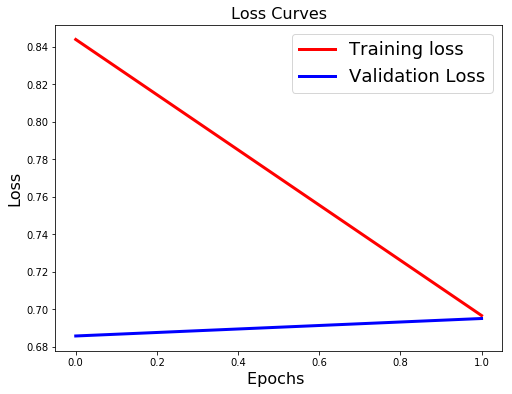

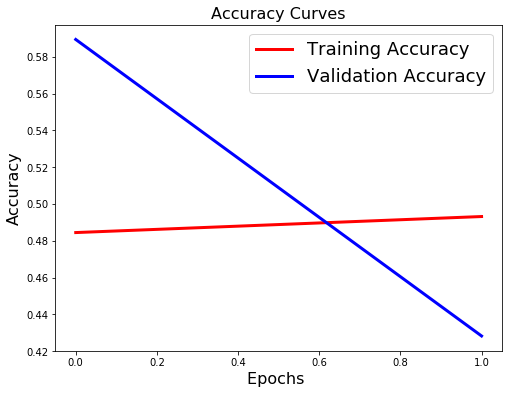

In [20]:
batch_size = 100
epochs = 2

datagen = ImageDataGenerator(
        zoom_range=0.1,        # randomly zoom into images
        rotation_range=5,      # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,# randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False    # randomly flip images
)
 

def is_binary(model):
    n_classes = model.get_layer('output').output_shape[1]
    return n_classes == 1
    
def compile_model(model):
    assert(K.image_data_format() == 'channels_last')
    
#     if is_binary(model):
#         loss= keras.losses.binary_crossentropy
#     else:
    loss=keras.losses.categorical_crossentropy
    
    model.compile(
        loss=loss,
#         optimizer=keras.optimizers.Adadelta(),
#         optimizer='rmsprop',
#         optimizer='sgd',
#         optimizer=keras.optimizers.SGD(lr=0.01),
        optimizer=keras.optimizers.Adam(),        
        metrics=['accuracy']
    )

def train(model, X_train, Y_train, X_test, Y_test, batch_size, epochs):
    compile_model(model)
    
    history = model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(X_test, Y_test)
           )
    return history

def train_gen(model, X_train, Y_train, X_test, Y_test, batch_size, epochs):
    compile_model(model)
    
    history = model.fit_generator(
        datagen.flow(X_train,
                     Y_train,
                     batch_size=batch_size
        ),
        steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
        epochs=epochs,
        validation_data=(X_test, Y_test),
        workers=4
    )
    return history
history = train(model, Xtrain[0], Ytrain, Xvalid[0], Yvalid, batch_size, epochs)
# history = train(model, Xtrain[1], Ytrain, Xvalid[1], Yvalid, batch_size, epochs)
# history = train_gen(model, Xtrain[0], Ytrain, Xvalid[0], Yvalid, batch_size, epochs)

show_train_curves(history)

In [ ]:
train_score = model.evaluate(Xtrain, Ytrain, verbose=1)
print('Train loss:', round(train_score[0], 3))
print(f'Train accuracy: {round(train_score[1] * 100, 2)}%')

valid_score = model.evaluate(Xvalid, Yvalid, verbose=1)
print('Test loss:', round(valid_score[0], 3))
valid_acc_str = f'{round(valid_score[1] * 100, 2)}%'
print(f'Test accuracy: {valid_acc_str}')


In [ ]:
print(f"types: {classes}")

print("train predictions, truth")
predictions_train =  model.predict(Xtrain, verbose=1)
show_prediction_list(predictions_train, Ytrain_oh)

print("test predictions, truth")
predictions_valid = model.predict(Xvalid, verbose=1)
show_prediction_list(predictions_valid, Yvalid_oh)

In [ ]:
idx = 11
print(ids_test[idx])
show_image(Xvalid, idx)

In [ ]:
# Y_train_idx = np.argmax(Y_train, axis=1)        
# Y_test_idx = np.argmax(Y_test, axis=1)

# print("train set:")
# show_prediction_images_new(Xtrain, Ytrain_oh, predictions_train, Ytrain_meta, enc, 10)

print("test set:")
show_prediction_images_new(Xvalid, Yvalid_oh, predictions_valid, Yvalid_meta, enc, 50)

In [ ]:
# def multi_class_to_binary(class_true: np.ndarray, class_pred: np.ndarray):
#     # Converting to probablilty that Y_true == 1
#     assert class_true.shape[1] == 2  # 2 classes
#     assert class_pred.shape[1] == 2  # 2 classes
#     assert class_true.shape[0] == class_pred.shape[0]
    
#     y_true = np.argmax(class_true, axis=1)
    
# #     pred_ids = np.argmax(class_pred, axis=1)
# #     y_prob = class_pred[range(class_pred.shape[0]), pred_ids]
#     y_prob = class_pred[:, 1]
#     assert y_true.shape == y_prob.shape
#     return [y_true, y_prob]
    
# [y_true, y_prob] = multi_class_to_binary(Y_test, predictions_test)


In [ ]:
print(Yvalid[0:20])
print(np.round(predictions_valid[0:20], 3))
predictions_valid.shape
# print(np.round(y_prob[0:10], 3))

In [ ]:
# class_pred = predictions_test
# pred_ids = np.argmax(class_pred, axis=1)
# y_prob = class_pred[range(class_pred.shape[0]), pred_ids]
y_prob = predictions_valid

In [ ]:
# reference https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

n_bins = 5

print(f'accuracy: {test_acc_str}')
conf_avg = np.average(predictions_test)
conf_avg_str = f'{round(conf_avg * 100, 2)}%'
print(f'confidence avg: {conf_avg_str}')

def draw_confidence_histogram(y_prob, n_bins):
    plt.figure()
    plt.title('Confidence histogram')
    plt.xlabel("Confidence")
    plt.ylabel("Sample count")
    plt.hist(y_prob, bins=n_bins)    
draw_confidence_histogram(y_prob, n_bins=n_bins)

def draw_reliability_curve(y_true, y_prob, n_bins):
    plt.figure()
    plt.title('Reliability curve')
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    [prob_true_bins, prob_pred_bins] = calibration_curve(y_true, y_prob, n_bins=n_bins)

    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(prob_pred_bins, prob_true_bins, marker='s')
draw_reliability_curve(y_true, y_prob, n_bins)
